# **Image Segmentation and Maskrcnn**

**1. Perform basic color-based segmentation to separate the blue color in an image**

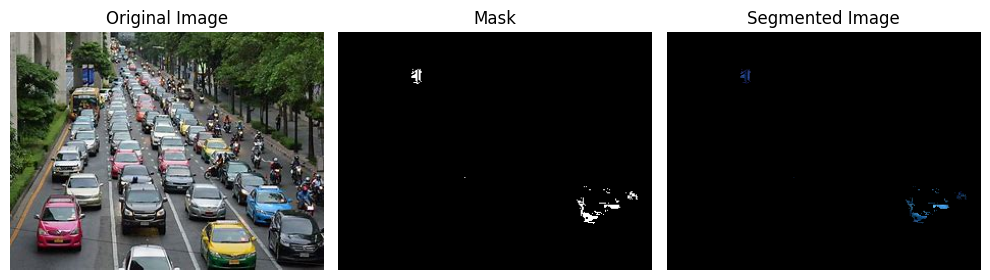

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image_path = "/content/traffic.jpg"  # Replace with your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Define the range for the blue color in HSV
lower_blue = np.array([100, 150, 50])  # Lower bound of blue (Hue, Saturation, Value)
upper_blue = np.array([140, 255, 255])  # Upper bound of blue

# Create a binary mask where blue colors are in range
mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

# Apply the mask to the original image
segmented_image = cv2.bitwise_and(image, image, mask=mask)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Segmented Image")
plt.imshow(segmented_image)
plt.axis("off")

plt.tight_layout()
plt.show()


**2. Use edge detection with Canny to highlight object edges in an image loaded**

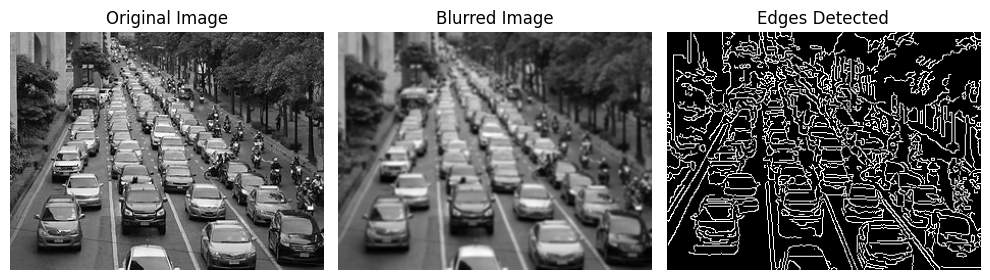

In [2]:
import cv2
from matplotlib import pyplot as plt

# Load the image
image_path = "/content/traffic.jpg"  # Replace with the path to your image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

# Apply Gaussian Blur to reduce noise
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Apply Canny edge detection
low_threshold = 50  # Lower bound for edge detection
high_threshold = 150  # Upper bound for edge detection
edges = cv2.Canny(blurred_image, low_threshold, high_threshold)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Blurred Image")
plt.imshow(blurred_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Edges Detected")
plt.imshow(edges, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


**3. Load a pretrained Mask R-CNN model from PyTorch and use it for object detection and segmentation on an
image**

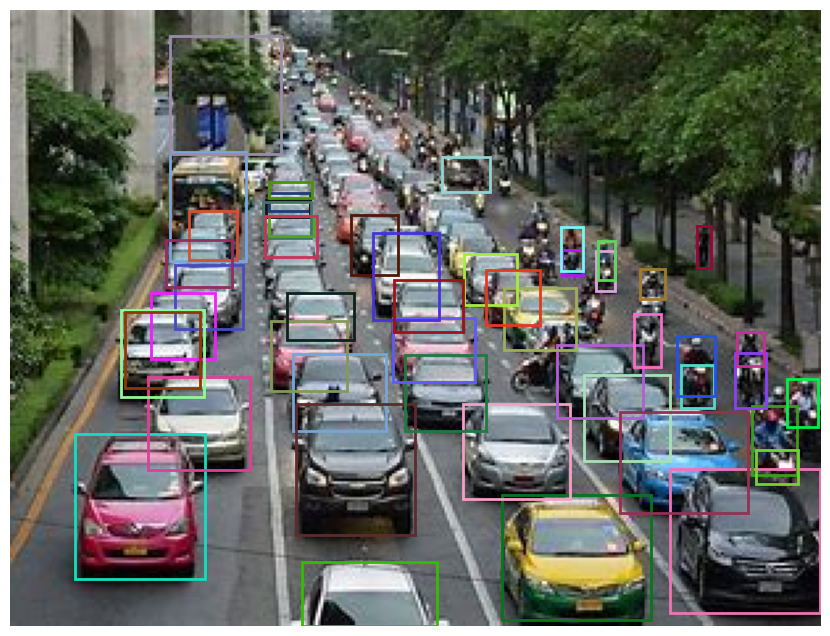

In [4]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# Load the pretrained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Load the input image
image_path = "/content/traffic.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Transform the image to tensor
image_tensor = F.to_tensor(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    outputs = model(image_tensor)

# Extract predictions
boxes = outputs[0]['boxes']  # Bounding boxes
labels = outputs[0]['labels']  # Class labels
scores = outputs[0]['scores']  # Confidence scores
masks = outputs[0]['masks']  # Segmentation masks

# Filter results based on a confidence threshold
confidence_threshold = 0.5
indices = [i for i, score in enumerate(scores) if score > confidence_threshold]

filtered_boxes = boxes[indices]
filtered_labels = labels[indices]
filtered_masks = masks[indices]

# Visualize results
def visualize(image, boxes, masks):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    # Overlay masks and bounding boxes
    for i in range(len(boxes)):
        # Get the mask for the object
        mask = masks[i, 0].mul(255).byte().cpu().numpy()

        # Random color for each object
        color = np.array([random.randint(0, 255) for _ in range(3)]) / 255.0

        # Apply the mask to the image
        image_array = np.array(image)
        mask_overlay = np.zeros_like(image_array, dtype=np.float32)
        mask_overlay[:, :, 0] = mask * color[0]
        mask_overlay[:, :, 1] = mask * color[1]
        mask_overlay[:, :, 2] = mask * color[2]
        image_array = image_array * 0.5 + mask_overlay * 0.5

        # Add bounding box
        box = boxes[i].cpu().numpy()
        plt.gca().add_patch(
            plt.Rectangle(
                (box[0], box[1]), box[2] - box[0], box[3] - box[1],
                fill=False, edgecolor=color, linewidth=2
            )
        )

    plt.axis("off")
    plt.show()

# Call the visualize function
visualize(np.array(image), filtered_boxes, filtered_masks)


**4. Generate bounding boxes for each object detected by Mask R-CNN in an image**

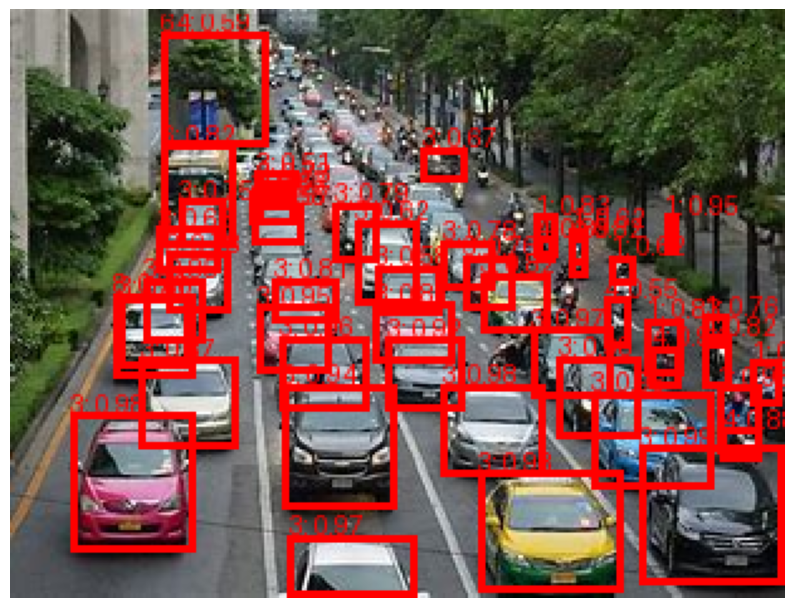

In [8]:
# Load the pretrained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Load the input image
image_path = "/content/traffic.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Transform the image to a tensor
image_tensor = F.to_tensor(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    outputs = model(image_tensor)

# Extract predictions
boxes = outputs[0]['boxes']  # Bounding boxes
labels = outputs[0]['labels']  # Class labels
scores = outputs[0]['scores']  # Confidence scores

# Filter results based on a confidence threshold
confidence_threshold = 0.5
filtered_indices = [i for i, score in enumerate(scores) if score > confidence_threshold]
filtered_boxes = boxes[filtered_indices]
filtered_labels = labels[filtered_indices]
filtered_scores = scores[filtered_indices]

# Visualize the bounding boxes
def visualize_boxes(image, boxes, labels, scores):
    draw = ImageDraw.Draw(image)
    for i, box in enumerate(boxes):
        box = box.cpu().numpy()
        label = labels[i].item()
        score = scores[i].item()

        # Draw bounding box
        draw.rectangle(
            [(box[0], box[1]), (box[2], box[3])],
            outline="red",
            width=3
        )

        # Annotate with label and score
        draw.text(
            (box[0], box[1] - 10),
            f"{label}: {score:.2f}",
            fill="red"
        )
    return image

# Call the visualization function
output_image = visualize_boxes(image.copy(), filtered_boxes, filtered_labels, filtered_scores)

# Show the output image
plt.figure(figsize=(10, 8))
plt.imshow(output_image)
plt.axis("off")
plt.show()


**5. Convert an image to grayscale and apply Otsu's thresholding method for segmentation**

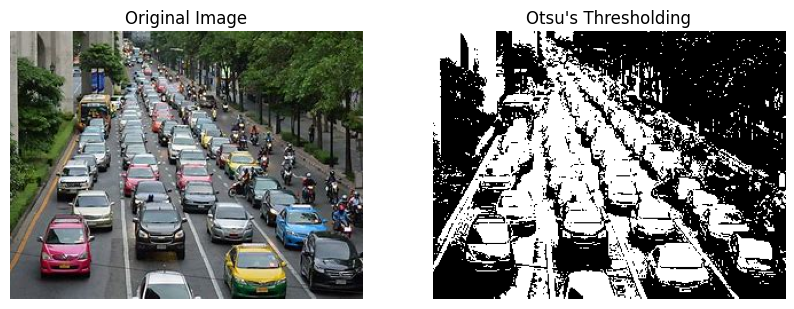

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/traffic.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Otsu's Thresholding method
# The second argument, 0, tells OpenCV to calculate the optimal threshold automatically
ret, otsu_thresholded = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Visualize the original and thresholded images side by side
plt.figure(figsize=(10, 5))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.title("Original Image")
plt.axis('off')

# Display the thresholded image
plt.subplot(1, 2, 2)
plt.imshow(otsu_thresholded, cmap='gray')
plt.title("Otsu's Thresholding")
plt.axis('off')

plt.show()


**6.  Perform contour detection in an image to detect distinct objects or shape**

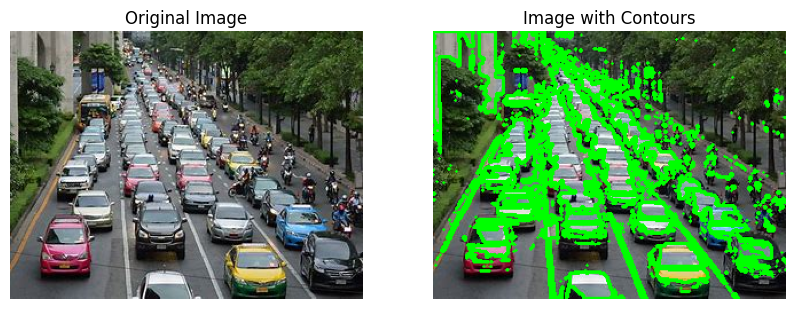

In [12]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/traffic.jpg'  # Replace with the path to your image
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding to prepare for contour detection
_, thresholded_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

# Detect contours in the thresholded image
# cv2.RETR_EXTERNAL retrieves only the outermost contours
# cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments
contours, hierarchy = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)  # Green contours with thickness of 2

# Display the results
plt.figure(figsize=(10, 5))

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("Original Image")
plt.axis('off')

# Show the image with contours
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("Image with Contours")
plt.axis('off')

plt.show()


**7 .Apply Mask R-CNN to detect objects and their segmentation masks in a custom image and display them**

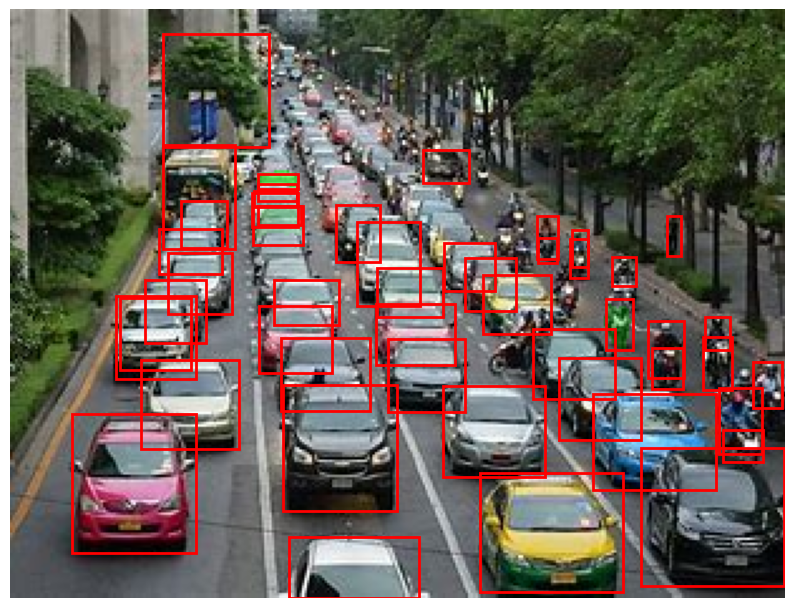

In [16]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# Step 1: Load the pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set model to evaluation mode

# Step 2: Load and preprocess the custom image
image_path = '/content/traffic.jpg'  # Replace with the path to your image
image = Image.open(image_path).convert("RGB")

# Apply the same transforms used during model training
transform = transforms.Compose([
    transforms.ToTensor()
])

image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Step 3: Perform inference (object detection and segmentation)
with torch.no_grad():
    prediction = model(image_tensor)

# Step 4: Process the results
# Extract bounding boxes, masks, and labels from the prediction
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
masks = prediction[0]['masks'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Set a threshold to filter out low-confidence detections
threshold = 0.5
valid_masks = masks[scores > threshold]
valid_boxes = boxes[scores > threshold]
valid_labels = labels[scores > threshold]

# Step 5: Display the results
# Convert the image to numpy for displaying with OpenCV
image_np = np.array(image)

# Plot the image with bounding boxes and segmentation masks
plt.figure(figsize=(10, 10))
plt.imshow(image_np)

# Loop through the valid detections and display each object
for i in range(len(valid_boxes)):
    # Get the bounding box and mask for each detected object
    box = valid_boxes[i]
    mask = valid_masks[i, 0]  # Take the first (and only) channel for the mask

    # Draw bounding box
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none'))

    # Apply the mask to the image
    mask = mask > 0.5  # Threshold the mask
    image_masked = image_np.copy()
    image_masked[mask] = [0, 255, 0]  # Color the mask green
    plt.imshow(image_masked, alpha=0.5)

plt.axis('off')
plt.show()


**9. Apply k-means clustering for segmenting regions in an image**

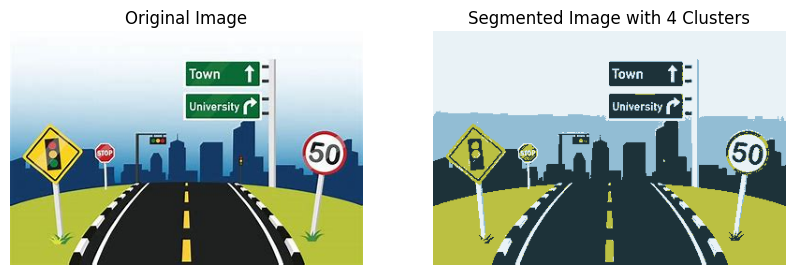

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image
image_path = '/content/OIP.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Convert the image from BGR to RGB (since OpenCV loads images in BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 2: Reshape the image into a 2D array (each pixel is a point in a 3D space - RGB)
pixels = image_rgb.reshape((-1, 3))  # Flatten the image into a 2D array of pixels (height * width, 3)

# Step 3: Apply K-means clustering
# Number of clusters (regions) to segment the image
k = 4
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(np.float32(pixels), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Step 4: Convert the centers to uint8 and assign the new centers to pixels
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]

# Step 5: Reshape the segmented image back to the original image shape
segmented_image = segmented_image.reshape(image_rgb.shape)

# Step 6: Display the original and segmented images
plt.figure(figsize=(10, 10))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

# Segmented Image
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title(f"Segmented Image with {k} Clusters")
plt.axis("off")

plt.show()
